In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load data
data = pd.read_csv('BTC.csv')

# Convert 'Date' to ordinal and drop 'Adj Close', 'High', and 'Low'
data['Date'] = pd.to_datetime(data['Date']).apply(lambda x: x.toordinal())
data.drop(['Adj Close', 'High', 'Low', 'Open'], axis=1, inplace=True)

# Drop any rows with null values to ensure data integrity
data.dropna(inplace=True)

In [ ]:
# Normalize the data separately for input features and the target (Close price)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.drop(columns=['Close']))  # Scale all except the target column

# Scale the target column separately
close_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = close_scaler.fit_transform(data[['Close']])

# Combine scaled data for LSTM processing
scaled_data = np.concatenate((scaled_data, scaled_close), axis=1)

In [ ]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :-1]  # All columns except the target
        X.append(a)
        Y.append(dataset[i + time_step, -1])  # Last column is the scaled 'Close' price
    return np.array(X), np.array(Y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Setup EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor the validation loss
    patience=10,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['mean_absolute_error'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Fit the model with early stopping
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.1163 - mean_absolute_error: 0.1163 - val_loss: 0.0902 - val_mean_absolute_error: 0.0902
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0830 - mean_absolute_error: 0.0830 - val_loss: 0.0812 - val_mean_absolute_error: 0.0812
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0826 - mean_absolute_error: 0.0826 - val_loss: 0.0810 - val_mean_absolute_error: 0.0810
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0835 - mean_absolute_error: 0.0835 - val_loss: 0.0709 - val_mean_absolute_error: 0.0709
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0800 - mean_absolute_error: 0.0800 - val_loss: 0.0656 - val_mean_absolute_error: 0.0656
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0801 - mean_absolute_error: 0.0801 - val_loss: 0.0795 - val_mean_absolute_error: 0.0795
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0774 - mean_absolute_error: 0.0774 - val_los

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Rescaled MAE:  1555.9606148286898


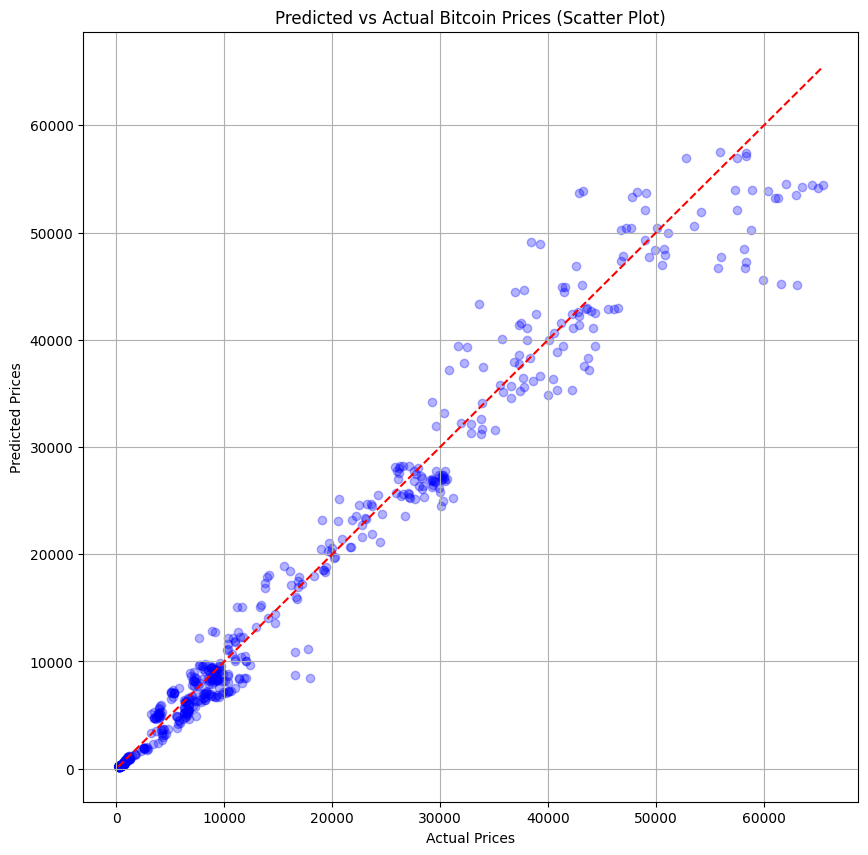

In [ ]:
# Make predictions
test_predict = model.predict(X_test)

# Inverse transform predictions and actuals
actual_prices = close_scaler.inverse_transform(y_test.reshape(-1, 1))
predicted_prices = close_scaler.inverse_transform(test_predict)

# Calculate Rescaled MAE
rescaled_mae = mean_absolute_error(actual_prices, predicted_prices)
print("Rescaled MAE: ", rescaled_mae)

# Scatter plot of actual vs predicted
plt.figure(figsize=(10, 10))
plt.scatter(actual_prices, predicted_prices, color='blue', alpha=0.3)  # Reduced alpha for better visibility

# Add a line for perfect predictions (y = x)
plt.plot([min(actual_prices), max(actual_prices)], [min(actual_prices), max(actual_prices)], color='red', linestyle='--')

plt.title('Predicted vs Actual Bitcoin Prices (Scatter Plot)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.show()




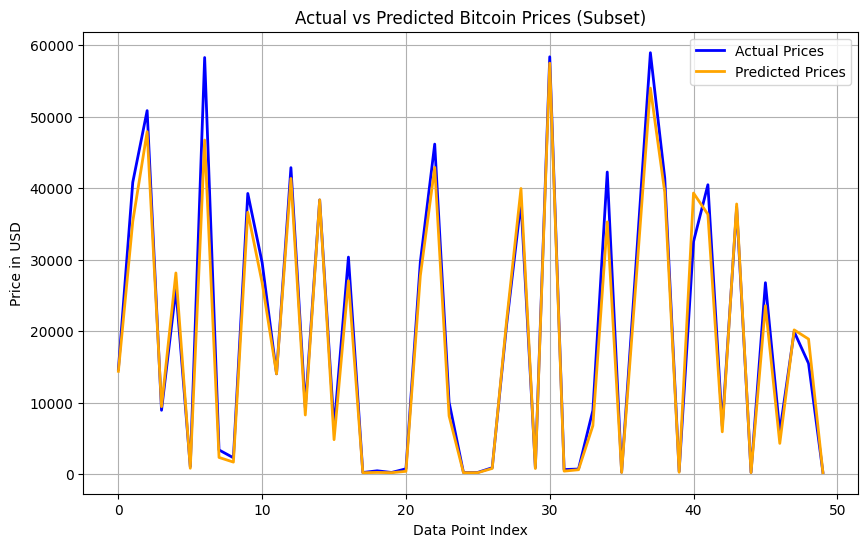

In [ ]:
# Line plot for a subset of data (e.g., 10 predictions)
subset_size = 50  # Number of data points to display
actual_subset = actual_prices[:subset_size].flatten()
predicted_subset = predicted_prices[:subset_size].flatten()
x_subset = range(subset_size)

plt.figure(figsize=(10, 6))
plt.plot(x_subset, actual_subset, label='Actual Prices', color='blue', linewidth=2)
plt.plot(x_subset, predicted_subset, label='Predicted Prices', color='orange', linewidth=2)

plt.title('Actual vs Predicted Bitcoin Prices (Subset)')
plt.xlabel('Data Point Index')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#lucas ignore
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
import datetime

# Step 1: Load and preprocess the data
data = pd.read_csv('BTC.csv')  # Replace with your CSV file name
data = data[['Date', 'Volume']].dropna()  # Keep only Date and Volume columns, and drop NaN values
data['Date'] = pd.to_datetime(data['Date']).apply(lambda x: x.toordinal())  # Convert Date to ordinal numbers

# Create a copy of the original dataset to keep it unscaled
data_unscaled = data.copy()

# Initialize scalers for date and volume
scaler_date = MinMaxScaler(feature_range=(0, 1))
scaler_volume = MinMaxScaler(feature_range=(0, 1))

# Scale the Date and Volume columns for model training
scaled_data = data.copy()
scaled_data['Date'] = scaler_date.fit_transform(data[['Date']])
scaled_data['Volume'] = scaler_volume.fit_transform(data[['Volume']])

# Prepare data for the LSTM model
X = scaled_data['Date'].values.reshape(-1, 1, 1)  # Reshape for LSTM: (samples, time steps, features)
y = scaled_data['Volume'].values  # Target values

# Define the LSTM model
def build_volume_model():
    model = Sequential([
        Input(shape=(1, 1)),  # Explicitly specify input shape
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(20, return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

model_volume = build_volume_model()

# Train the model
model_volume.fit(X, y, epochs=30, batch_size=32, verbose=1)

# Predict the volume for the next day
most_recent_date = data_unscaled['Date'].max()  # Most recent unscaled date in the data
next_date = most_recent_date + 1  # Next ordinal date

# Wrap the next_date in a DataFrame with the same column name as used during fitting
next_date_scaled = scaler_date.transform(pd.DataFrame({'Date': [next_date]}))  # Scale the next date
next_date_scaled = next_date_scaled.reshape(1, 1, 1)  # Reshape for LSTM input

predicted_volume_scaled = model_volume.predict(next_date_scaled).flatten()[0]
predicted_volume_unscaled = scaler_volume.inverse_transform([[predicted_volume_scaled]])[0][0]

# Output the predicted volume
print(f"Predicted Volume for {datetime.date.fromordinal(int(next_date))}: {predicted_volume_unscaled}")

# Add the predicted date and volume to the original (unscaled) dataset
new_row = pd.DataFrame({'Date': [next_date], 'Volume': [predicted_volume_unscaled]})
data_unscaled = pd.concat([data_unscaled, new_row], ignore_index=True)

# Print the last few rows of the updated unscaled dataset
print("\nUpdated Dataset (Human-Readable, Last Few Rows):")
print(data_unscaled.tail())

# Prepare the updated dataset for model retraining by rescaling
scaled_data = data_unscaled.copy()
scaled_data['Date'] = scaler_date.fit_transform(data_unscaled[['Date']])
scaled_data['Volume'] = scaler_volume.fit_transform(data_unscaled[['Volume']])

# Print the last few rows of the scaled dataset for verification
print("\nUpdated Dataset (Scaled, Last Few Rows):")
print(scaled_data.tail())


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import datetime

# Step 1: Load the BTC data (10 years of data)
btc_data = pd.read_csv('BTC.csv')  # Replace with your actual file name
btc_data = btc_data[['Date', 'Volume', 'Close']].dropna()

# Convert 'Date' to ordinal for easier processing
btc_data['Date'] = pd.to_datetime(btc_data['Date']).apply(lambda x: x.toordinal())

# Step 2: Scaling the data
scaler_date = MinMaxScaler(feature_range=(0, 1))
scaler_volume = MinMaxScaler(feature_range=(0, 1))
scaler_close = MinMaxScaler(feature_range=(0, 1))

btc_data['Date'] = scaler_date.fit_transform(btc_data[['Date']])
btc_data['Volume'] = scaler_volume.fit_transform(btc_data[['Volume']])
btc_data['Close'] = scaler_close.fit_transform(btc_data[['Close']])

# Step 3: Create training data
def create_training_data(data):
    X, y = [], []
    for i in range(1, len(data)):
        X.append([data.iloc[i, 0], data.iloc[i, 1], data.iloc[i - 1, 2]])  # Date, Volume, Previous Close
        y.append(data.iloc[i, 2])  # Target: Current day's Close
    return np.array(X), np.array(y)

# Prepare training data
X_train, y_train = create_training_data(btc_data)

# Reshape X for LSTM input: (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Step 4: Build and train the LSTM model
def build_model():
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(1, X_train.shape[2])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Predict Close price
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
    return model

model = build_model()

# Add EarlyStopping for stability
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, callbacks=[early_stop])

# Step 5: Predict the Close price for the first day using predicted (Date, Volume)
# Use the predicted Volume and Date from previous predictions
predicted_volume_df = pd.DataFrame({
    'Date': [btc_data['Date'].max() + i * 0.001 for i in range(1, 61)],  # Simulated next 60 days' Dates
    'Volume': np.random.random(size=60)  # Replace with real predicted Volumes
})

# Use the most recent 'Close' price as input
most_recent_close = btc_data['Close'].iloc[-1]

# Predict the Close price for the first day
first_day_input = np.array([
    [predicted_volume_df['Date'].iloc[0], predicted_volume_df['Volume'].iloc[0], most_recent_close]
])
first_day_input = first_day_input.reshape((1, 1, 3))  # Reshape for LSTM

predicted_close_scaled = model.predict(first_day_input).flatten()[0]
predicted_close_unscaled = scaler_close.inverse_transform([[predicted_close_scaled]])[0][0]

# Step 6: Add the predicted row to the dataset
# Ensure all dates are in datetime format, then extract the date part
btc_data_unscaled = pd.read_csv('BTC.csv')  # Reload to get original unscaled data
btc_data_unscaled = btc_data_unscaled[['Date', 'Volume', 'Close']].dropna()
btc_data_unscaled['Date'] = pd.to_datetime(btc_data_unscaled['Date']).dt.date

# Find the most recent date
last_date = btc_data_unscaled['Date'].max()
new_date_datetime = last_date + datetime.timedelta(days=1)  # Increment by one day

# Unscale the predicted values
new_volume_unscaled = scaler_volume.inverse_transform([[predicted_volume_df['Volume'].iloc[0]]])[0][0]

# Create a new row with unscaled values
new_row = {
    'Date': new_date_datetime,  # Use datetime format here
    'Volume': new_volume_unscaled,
    'Close': predicted_close_unscaled
}

# Convert the new row into a DataFrame and concatenate
new_row_df = pd.DataFrame([new_row])
btc_data_unscaled = pd.concat([btc_data_unscaled, new_row_df], ignore_index=True)

# Print confirmation
print("\nNew row added to the dataset:")
print(new_row_df)

# Step 7: Update and rescale the dataset for future retraining
btc_data_updated = btc_data_unscaled.copy()

# Ensure the Date is in ordinal format for scaling
btc_data_updated['Date'] = btc_data_updated['Date'].apply(lambda x: x.toordinal())

# Rescale the updated dataset
btc_data_updated['Date'] = scaler_date.fit_transform(btc_data_updated[['Date']])
btc_data_updated['Volume'] = scaler_volume.fit_transform(btc_data_updated[['Volume']])
btc_data_updated['Close'] = scaler_close.fit_transform(btc_data_updated[['Close']])

# Print last few rows of the updated dataset
print("\nUpdated dataset (scaled, last 5 rows):")
print(btc_data_updated.tail())

# Step 8: Convert the dataset back to human-readable format
btc_data_human_readable = btc_data_updated.copy()

# Inverse-transform the columns
btc_data_human_readable['Date'] = scaler_date.inverse_transform(btc_data_updated[['Date']])
btc_data_human_readable['Volume'] = scaler_volume.inverse_transform(btc_data_updated[['Volume']])
btc_data_human_readable['Close'] = scaler_close.inverse_transform(btc_data_updated[['Close']])

# Convert 'Date' back to datetime format
btc_data_human_readable['Date'] = btc_data_human_readable['Date'].apply(lambda x: datetime.date.fromordinal(int(x)))

# Print the dataset in human-readable format
print("\nUpdated dataset (human-readable, last 5 rows):")
print(btc_data_human_readable.tail())

# Step 9: Output the result
print(f"\nPredicted Close Price for {new_date_datetime}: {predicted_close_unscaled}")
